# <center>Modelling</center>

## Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 999
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras import optimizers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import xgboost
import warnings
warnings.filterwarnings("ignore")

## Load data

In [5]:
PATH = 'preprocessing_categorical/'

In [6]:
X_train = pd.read_csv(PATH + 'X_train.csv', index_col=0)
y_train = pd.read_csv(PATH + 'y_train.csv', index_col=0)
y_train_categories = pd.read_csv(PATH + 'y_train_categories.csv', index_col=0)
y_train_one_hot = pd.read_csv(PATH + 'y_train_one_hot.csv', index_col=0)

In [7]:
X_train_os = pd.read_csv(PATH + 'X_train_os.csv', index_col=0)
y_train_os = pd.read_csv(PATH + 'y_train_os.csv', index_col=0)
y_train_os_categories = pd.read_csv(PATH + 'y_train_os_categories.csv', index_col=0)
y_train_os_one_hot = pd.read_csv(PATH + 'y_train_os_one_hot.csv', index_col=0)

In [5]:
PATH = 'Dataset/'
PATH_TO_test_data = PATH + 'test.csv'
test_data = pd.read_csv(PATH_TO_test_data)

In [6]:
X_test = pd.read_csv('X_test.csv', index_col=0)

In [7]:
def save_predictions(y_test_pred, test_data, add_one_or_not=True):
    y_test_pred_df = pd.DataFrame({'damage_grade': y_test_pred})
    if add_one_or_not == True:
        y_test_pred_df['damage_grade'] += 1
    y_test_pred_df = y_test_pred_df.astype(str)
    y_test_pred_df['damage_grade'] = 'Grade ' + y_test_pred_df['damage_grade']

    # Add building_id to the Data frame.
    y_test_pred_df['building_id'] = test_data.building_id
    y_test_pred_df = pd.DataFrame({'building_id': y_test_pred_df.building_id, 'damage_grade': y_test_pred_df.damage_grade})
    y_test_pred_df.to_csv('prediction.csv', index=False)
    return y_test_pred_df

In [8]:
def feature_importance(model, X_train):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X_train.columns
    important_features = []
    important_features_scores = []
    for index in indices:
        important_features.append(features[index])
        important_features_scores.append(importances[index])
    feature_importance_df = pd.Series(data=important_features_scores, index=important_features)
    return feature_importance_df

## Drop highly correlated columns

In [9]:
corr_matrix = X_train_os.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [10]:
X_train_os = X_train_os.drop(columns=to_drop)

In [11]:
X_train_os.shape

(1021990, 80)

In [34]:
X_test = X_test.drop(columns=to_drop)

## Modelling

In [1]:
model = Sequential()
model.add(Dense(50, activation='tanh', kernel_initializer='random_uniform',
                bias_initializer='zeros', input_shape=(X_train_os.shape[1],)))
# model.add(Dropout(0.3))
model.add(Dense(40, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.2))
model.add(Dense(30, activation='tanh'))
# model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

NameError: name 'Sequential' is not defined

In [24]:
sgd = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [26]:
model.fit(X_train_os, y_train_os_one_hot, epochs= 3, batch_size = 1000)

Epoch 1/3
1021990/1021990 [==============================] - 7s 7us/step - loss: 1.6109 - acc: 0.1910
Epoch 2/3
1021990/1021990 [==============================] - 9s 9us/step - loss: 1.6108 - acc: 0.1913
Epoch 3/3
1021990/1021990 [==============================] - 8s 8us/step - loss: 1.6107 - acc: 0.1920


# Random Forest Classifier

In [27]:
# rfClassifier = RandomForestClassifier()
# model = rfClassifier.fit(X_train_os, y_train_os_one_hot)

In [40]:
# dtClassifier = DecisionTreeClassifier(max_depth=100, min_samples_leaf=10, class_weight='balanced')
dtClassifier = DecisionTreeClassifier()
model = dtClassifier.fit(X_train_os, y_train_os_one_hot)

In [41]:
model

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
y_train_pred = model.predict(X_train_os)
Accuracy = accuracy_score(y_train_os_one_hot, y_train_pred) * 100
F1_score = f1_score(y_train_os_one_hot, y_train_pred, average='weighted')

In [43]:
y_train_pred

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [44]:
Accuracy, F1_score

(99.76379416628343, 0.9987718048372939)

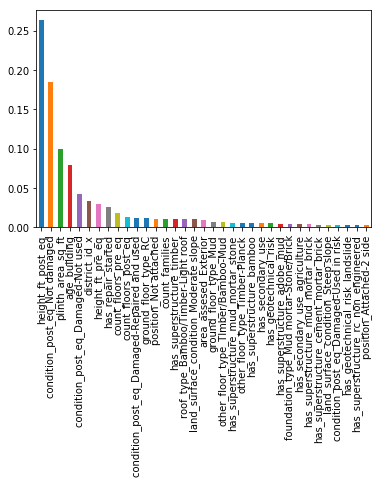

In [45]:
feature_importance_df = feature_importance(model, X_train_os)
feature_importance_df.iloc[:35].plot('bar')

In [46]:
y_test_pred = model.predict(X_test)
y_test_pred

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [47]:
y_test_pred_int = np.argmax(y_test_pred, axis=1)
y_test_pred_int

array([3, 4, 4, ..., 0, 4, 4])

In [48]:
out = save_predictions(y_test_pred_int, test_data)

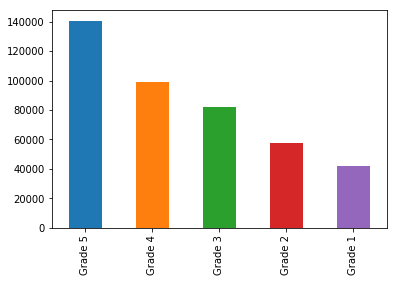

In [49]:
out.damage_grade.value_counts().plot('bar')